In [6]:
#IMPORTS

import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "True"
import cv2
import numpy as np
from ultralytics import YOLO
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
from typing import List
import dm3_lib as dm3  # libreria en la misma carpeta
from PIL import Image


In [7]:
class YOLOSegmentation:
    def __init__(self, model_path: str) -> None:
        """
        Initialize the YOLOSegmentation object with the specified model path.

        Args:
        model_path (str): The path to the YOLO model.
        """
        self.model = YOLO(model_path)
        # self.model.to("cuda")

    def detect(self, img: np.ndarray) -> tuple:
        """
        Detect objects in the input image using the YOLO model.

        Args:
        img (np.ndarray): The input image.

        Returns:
        tuple: A tuple containing the bounding boxes, class IDs, segmentation contours, and scores.
        """
        # Get image shape
        height, width, channels = img.shape
        results = self.model.predict(source=img.copy(), save_conf=True, max_det=500)
        result = results[0]
        segmentation_contours = []
        if result.masks is not None:
            for seg in result.masks.segments:
                # Scale the segments to match the image dimensions
                seg[:, 0] *= width
                seg[:, 1] *= height
                segment = np.array(seg, dtype=np.int32)
                segmentation_contours.append(segment)

        bounding_boxes = np.array(result.boxes.xyxy.cpu(), dtype="int")
        # Get class IDs
        class_ids = np.array(result.boxes.cls.cpu(), dtype="int")
        # Get scores
        scores = np.array(result.boxes.conf.cpu(), dtype="float").round(2)
        return bounding_boxes, class_ids, segmentation_contours, scores

In [8]:
def process_dm3_image(file_path: str) -> np.ndarray:
    """
    Process a DM3 image file and return the preprocessed image.

    Args:
    file_path (str): The file path of the DM3 image.

    Returns:
    np.ndarray: The preprocessed image.
    """
    dm3_file = dm3.DM3(file_path)
    image_data = dm3_file.imagedata
    pixel_size = dm3_file.pxsize
    cuts = dm3_file.cuts
    min_cut, max_cut = cuts[0], cuts[1]

    # Normalize image for conversion to 8-bit
    normalized_image = image_data.copy()
    normalized_image[(image_data <= min_cut)] = float(min_cut)
    normalized_image[(image_data >= max_cut)] = float(max_cut)
    normalized_image = (normalized_image - np.min(normalized_image)) / (np.max(normalized_image) - np.min(normalized_image))
    img_8bit = np.uint8(np.round(normalized_image * 255))

    # Preprocessing image
    img_bgr = cv2.cvtColor(img_8bit, cv2.COLOR_RGB2BGR)

    return img_bgr, dm3_file.width, dm3_file.height, pixel_size[0]



In [9]:
def detect_and_visualize_nps(image, pixel_size):
    """
    Detects nanoparticles in the given image, calculates mean diameter, and visualizes the results.

    Args:
    image (numpy.ndarray): The input image.
    pixel_size (float): The size of each pixel in nanometers.

    Returns:
    float: Mean diameter of nanoparticles.
    """
    # Segmentation detector Model
    ys = YOLOSegmentation("best15x.pt")

    # Detect nanoparticles
    bboxes, classes, segmentations, scores = ys.detect(image)
    sizes = []

    original_image = image.copy()
    for bbox, class_id in zip(bboxes, classes):
        (x, y, x2, y2) = bbox
        cv2.rectangle(image, (x, y), (x2, y2), (255, 0, 0), 2)
        sizes.append((abs(x - x2) + abs(y - y2)) / 2 * float(pixel_size))

    mean_diameter = sum(sizes) / len(sizes)
 
    # Visualize results
    img_resized = cv2.resize(original_image, (800, 800))
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(original_image)
    ax[1].imshow(image)

    sizes = np.array(sizes)
    
    fig1, ax1 = plt.subplots()
    
    # Fit a normal distribution to the data
    mu, std = norm.fit(sizes)

    # Plot the histogram
    ax1.hist(sizes, bins=25, alpha=0.6, color="#98ff98", histtype="bar", ec="black")

    # Plot the PDF
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    p *= 50 / max(p)
    plt.plot(x, p, "k", linewidth=2)
    title = "Fit Values: {:.2f} and {:.2f}".format(mu, std)
    plt.title(title)
    plt.show()
    


0: 640x640 500 Particles, 1601.6ms
Speed: 6.5ms preprocess, 1601.6ms inference, 15.5ms postprocess per image at shape (1, 3, 640, 640)


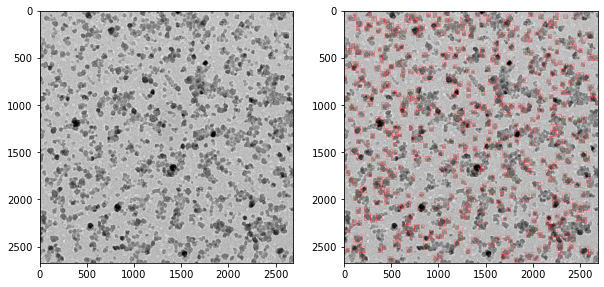

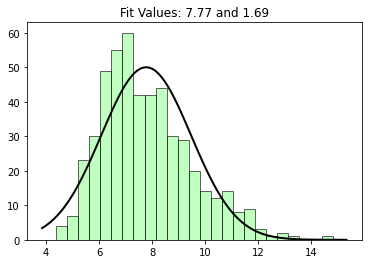

In [11]:
image, width, height, pixel_size = process_dm3_image("images/DBZO17_stability_50000X_0004.dm3")

detect_and_visualize_nps(image, pixel_size)
